In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import torch
import random

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from Weighted_VP_model import *
sys.path.append(os.path.abspath('../Weighted_VP_model'))

# Now you can import net.py from vpnet
from vpnet import *
from vpnet.vp_functions import *


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
notebook_dir = os.getcwd()

In [3]:
csv_path = os.path.join(notebook_dir, '..', 'data', 'raw_data.csv')
csv_path = os.path.abspath(csv_path)
raw_data = pd.read_csv(csv_path)
raw_data.info()
raw_data[:10]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071475 entries, 0 to 8071474
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   raw_ts         float64
 1   raw_amplitude  float64
dtypes: float64(2)
memory usage: 123.2 MB


,raw_ts,raw_amplitude
0,2000.000049,1.522938
1,2000.000149,1.458149
2,2000.000249,1.004952
3,2000.000349,-0.116204
4,2000.000449,-0.809816
5,2000.000549,-0.682868
6,2000.000649,-0.449690
7,2000.000749,-0.259925
8,2000.000849,0.224188
9,2000.000949,0.443881


In [4]:
csv_path = os.path.join(notebook_dir, '..', 'data', 'spike_timestamps.csv')
csv_path = os.path.abspath(csv_path)
ground_truth_spikes = pd.read_csv(csv_path)
ground_truth_spikes.info()
ground_truth_spikes[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   spike_idx  536 non-null    int64  
 1   spike_ts   536 non-null    float64
 2   track      536 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.7+ KB


,spike_idx,spike_ts,track
0,0,2000.062149,Track3
1,1,2000.073049,Track4
2,2,2004.062249,Track3
3,3,2004.073149,Track4
4,4,2008.062349,Track3
5,5,2008.073049,Track4
6,6,2012.062349,Track3
7,7,2012.073149,Track4
8,8,2016.059667,Track3
9,9,2016.070467,Track4


In [5]:
csv_path = os.path.join(notebook_dir, '..', 'data', 'stimulation_timestamps.csv')
csv_path = os.path.abspath(csv_path)
stimulation = pd.read_csv(csv_path)
stimulation.info()
stimulation[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stimulation_idx  267 non-null    int64  
 1   stimulation_ts   267 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.3 KB


,stimulation_idx,stimulation_ts
0,0,2003.838249
1,1,2007.838249
2,2,2011.838249
3,3,2015.835667
4,4,2016.085667
5,5,2016.335667
6,6,2016.585667
7,7,2019.835550
8,8,2023.835550
9,9,2027.835550


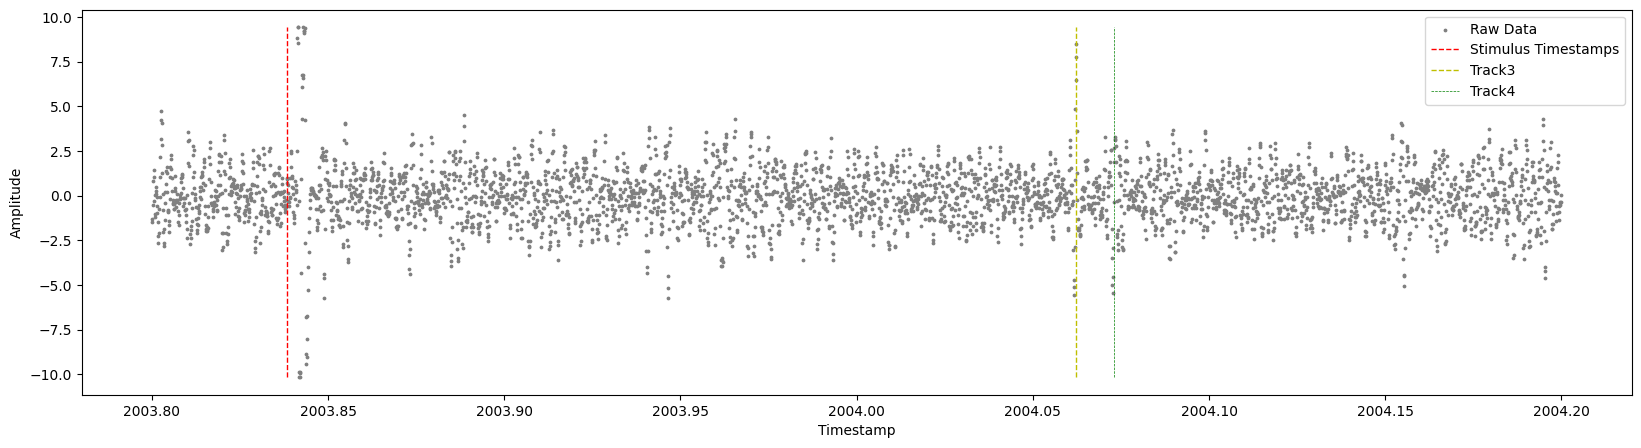

In [86]:
df_first_part = raw_data_df.iloc[38000:42000]

def plot_data(df_first_part):
    # Get the range of the timestamps from the first 2000 points
    min_ts = df_first_part['raw_ts'].min()
    max_ts = df_first_part['raw_ts'].max()

    # 2. Filter timestamps that fall within the plotted range
    df_timestamps_in_range = stimulation[
        (stimulation['stimulation_ts'] >= min_ts) & (stimulation['stimulation_ts'] <= max_ts)
    ]

    df_timestamps_in_range_gt = ground_truth_spikes[
        (ground_truth_spikes['spike_ts'] >= min_ts) & (ground_truth_spikes['spike_ts'] <= max_ts)
    ]

    plt.figure(figsize=(20, 5))
    plt.scatter(df_first_part['raw_ts'], df_first_part['raw_amplitude'], label='Raw Data', color='gray', s=3)

    # 4. Plot the filtered timestamps as dots
    #plt.scatter(df_timestamps_in_range['stimulation_ts'], 
    #            [df_first_part['raw_amplitude'].mean()] * len(df_timestamps_in_range),  # Positioning dots at mean amplitude level
    #            color='r', marker='o', label='Stimulus Timestamps', zorder=5)

    plt.vlines(df_timestamps_in_range['stimulation_ts'], 
            ymin=df_first_part['raw_amplitude'].min(), 
            ymax=df_first_part['raw_amplitude'].max(), 
            color='r', linestyle='--', label='Stimulus Timestamps', linewidth=1)

    df_value1 = df_timestamps_in_range_gt[df_timestamps_in_range_gt['track'] == 'Track3']  # For yellow lines
    df_value2 = df_timestamps_in_range_gt[df_timestamps_in_range_gt['track'] == 'Track4']


    plt.vlines(df_value1['spike_ts'], 
            ymin=df_first_part['raw_amplitude'].min(), 
            ymax=df_first_part['raw_amplitude'].max(), 
            color='y', linestyle='--', label='Track3', linewidth=1)

    # 5. Plot vertical lines for the second group (green)
    plt.vlines(df_value2['spike_ts'], 
            ymin=df_first_part['raw_amplitude'].min(), 
            ymax=df_first_part['raw_amplitude'].max(), 
            color='g', linestyle='--', label='Track4', linewidth=0.5)

    # Customize plot
    plt.xlabel('Timestamp')
    plt.ylabel('Amplitude')
    plt.legend()

    # Show the plot
    plt.show()

plot_data(df_first_part)

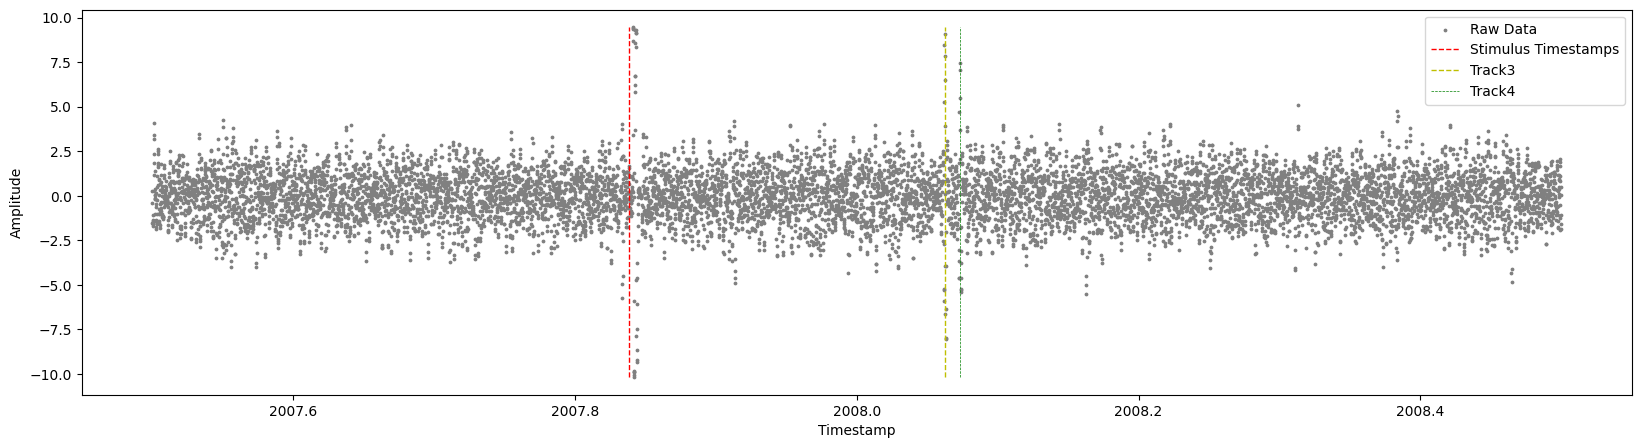

In [62]:
df_first_part = raw_data_df.iloc[75000:85000]
plot_data(df_first_part)

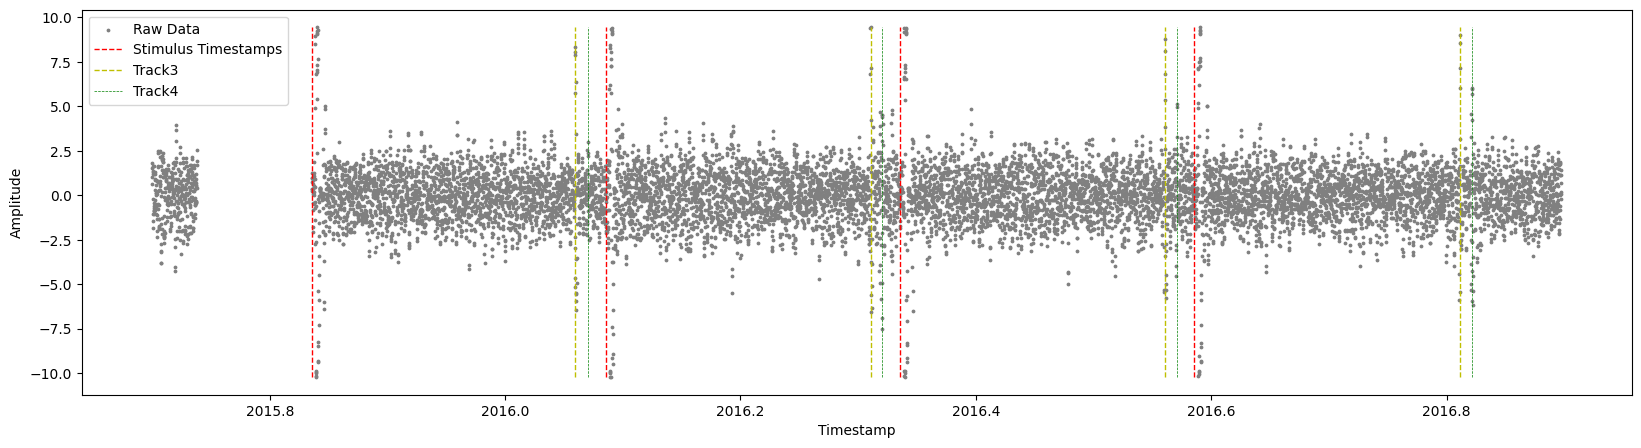

In [77]:
df_first_part = raw_data_df.iloc[157000:168000]
plot_data(df_first_part)

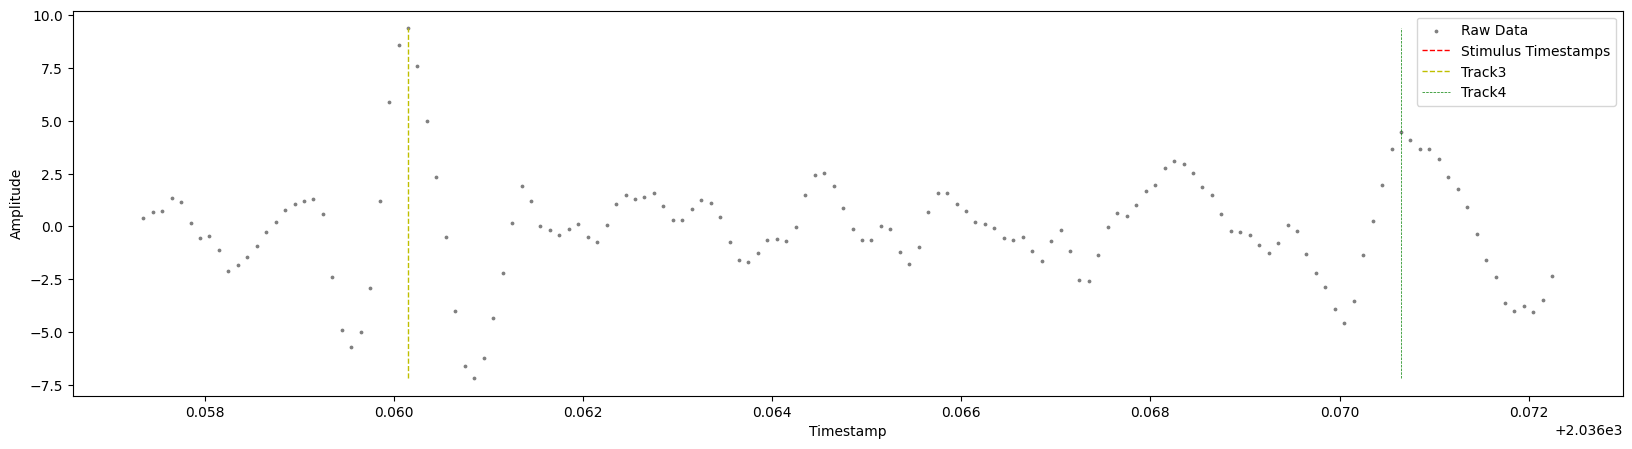

In [122]:
df_first_part = raw_data_df.iloc[358600:358750]
plot_data(df_first_part)

In [6]:
df1 = ground_truth_spikes.rename(columns={'spike_ts': 'ts'})
df2 = stimulation.rename(columns={'stimulation_ts': 'ts'})

all_spike = pd.merge(df1, df2[['ts']], on='ts', how='outer')

# Fill missing track values with 'X'
all_spike['track'] = all_spike['track'].fillna('X')

# Sort by timestamp if needed
all_spike = all_spike.sort_values('ts').reset_index(drop=True)
all_spike = all_spike.drop(columns=['spike_idx'])

all_spike[:10]

,ts,track
0,2000.062149,Track3
1,2000.073049,Track4
2,2003.838249,X
3,2004.062249,Track3
4,2004.073149,Track4
5,2007.838249,X
6,2008.062349,Track3
7,2008.073049,Track4
8,2011.838249,X
9,2012.062349,Track3


In [7]:
time_diffs = all_spike['ts'].diff().dropna()
min_gap = time_diffs.min()
max_gap = time_diffs.max()

print(f"Minimum gap between timestamps: {min_gap}")
print(f"Maximum gap between timestamps: {max_gap}")

raw_time_diffs = raw_data['raw_ts'].diff().dropna()
print(raw_time_diffs.min()) # 0.00009999999929277692
print(min_gap / raw_time_diffs.min())

Minimum gap between timestamps: 0.004800000000614091
Maximum gap between timestamps: 3.7723134070752167
9.999999929277692e-05
48.00000034560799


In [77]:
# continuous windows
# 
def slice_column_to_matrice(df, window_size, column_name):
    num_windows = len(df) // window_size
    matrix = df[column_name].values[:num_windows * window_size].reshape(num_windows, window_size)
    return matrix

timestamps = slice_column_to_matrice(raw_data, 48, 'raw_ts')
amplitudes = slice_column_to_matrice(raw_data, 48, 'raw_amplitude')



def slice_column_to_matrice(df, window_size, overlap, column_name):
    stride = window_size - overlap  # Define the stride (how much the window shifts)
    num_windows = (len(df) - window_size) // stride + 1  # Calculate number of windows
    matrix = np.array([df[column_name].values[i:i + window_size] for i in range(0, len(df) - window_size + 1, stride)])
    return matrix

# Example usage
timestamps = slice_column_to_matrice(raw_data, window_size=48, overlap=24, column_name='raw_ts')
amplitudes = slice_column_to_matrice(raw_data, window_size=48, overlap=24, column_name='raw_amplitude')


In [78]:
# windows around spikes

def slice_windows(raw_data, spike_timestamps, window_size):
    # Create a list to store windows
    ts_windows = []
    ampl_windows = []
    used_indices = []
    
    # Step 1: Get non-overlapping windows around matching timestamps
    for timestamp in spike_timestamps:
        # Find index of the timestamp in raw_data
        if timestamp in raw_data['raw_ts'].values:
            index = raw_data[raw_data['raw_ts'] == timestamp].index[0]
            # Calculate start and end of the window
            start = max(0, index - window_size // 2)
            end = min(len(raw_data), start + window_size)
            if end - start != 48:
                continue
            window = raw_data['raw_ts'].values[start:end]
            ts_windows.append(window)
            am_window = raw_data['raw_amplitude'].values[start:end]
            ampl_windows.append(am_window)
            used_indices.extend(range(start, end))
    used_indices = sorted(used_indices)

    # Iterate over the raw data to extract remaining non-overlapping windows
    for i in range(0, len(raw_data), window_size):
        if any(index in used_indices for index in range(i, i + window_size)):
            continue
        window = raw_data['raw_ts'].values[i:i + window_size]
        ts_windows.append(window)
        window_am = raw_data['raw_amplitude'].values[i:i + window_size]
        ampl_windows.append(window_am)
    
    return ts_windows, ampl_windows

# Example usage
# raw_data = pd.DataFrame({'raw_ts': [...]})  # Your raw data here
# reference_data = pd.DataFrame({'timestamp': [...]})  # Your reference timestamps here
window_size = 48
sliced_ts, sliced_ampl = slice_windows(raw_data, all_spike['ts'], window_size)

KeyboardInterrupt: 

In [21]:
result_list = []

# Iterate over each row (window) in the timestamps matrix
for i, window in enumerate(timestamps):
    # Find timestamps from df_types that match any timestamp in the current window
    matching_rows = all_spike[all_spike['ts'].isin(window)]
    
    # Check how many matches were found
    if len(matching_rows) == 1:
        # If one match is found, append the corresponding type to the result list
        result_list.append(matching_rows['track'].values[0])
    elif len(matching_rows) > 1:
        # If more than one match is found, raise an error
        raise ValueError(f"Multiple timestamps matched in window {i} with details: {matching_rows}")
    else:
        # If no match is found, append 0 to the result list
        result_list.append(0)

In [22]:
import pickle

with open('../data/labels.pkl', 'wb') as file:
    pickle.dump(result_list, file)


with open('../data/samples.pkl', 'wb') as file:
    pickle.dump(amplitudes, file)

In [9]:
import pickle

# Load the labels
with open('../data/labels.pkl', 'rb') as file:
    result_list = pickle.load(file)

# Load the samples
with open('../data/samples.pkl', 'rb') as file:
    amplitudes = pickle.load(file)

In [12]:
print(len(amplitudes))
print(len(timestamps))
print(len(result_list))

168155
168155
168155


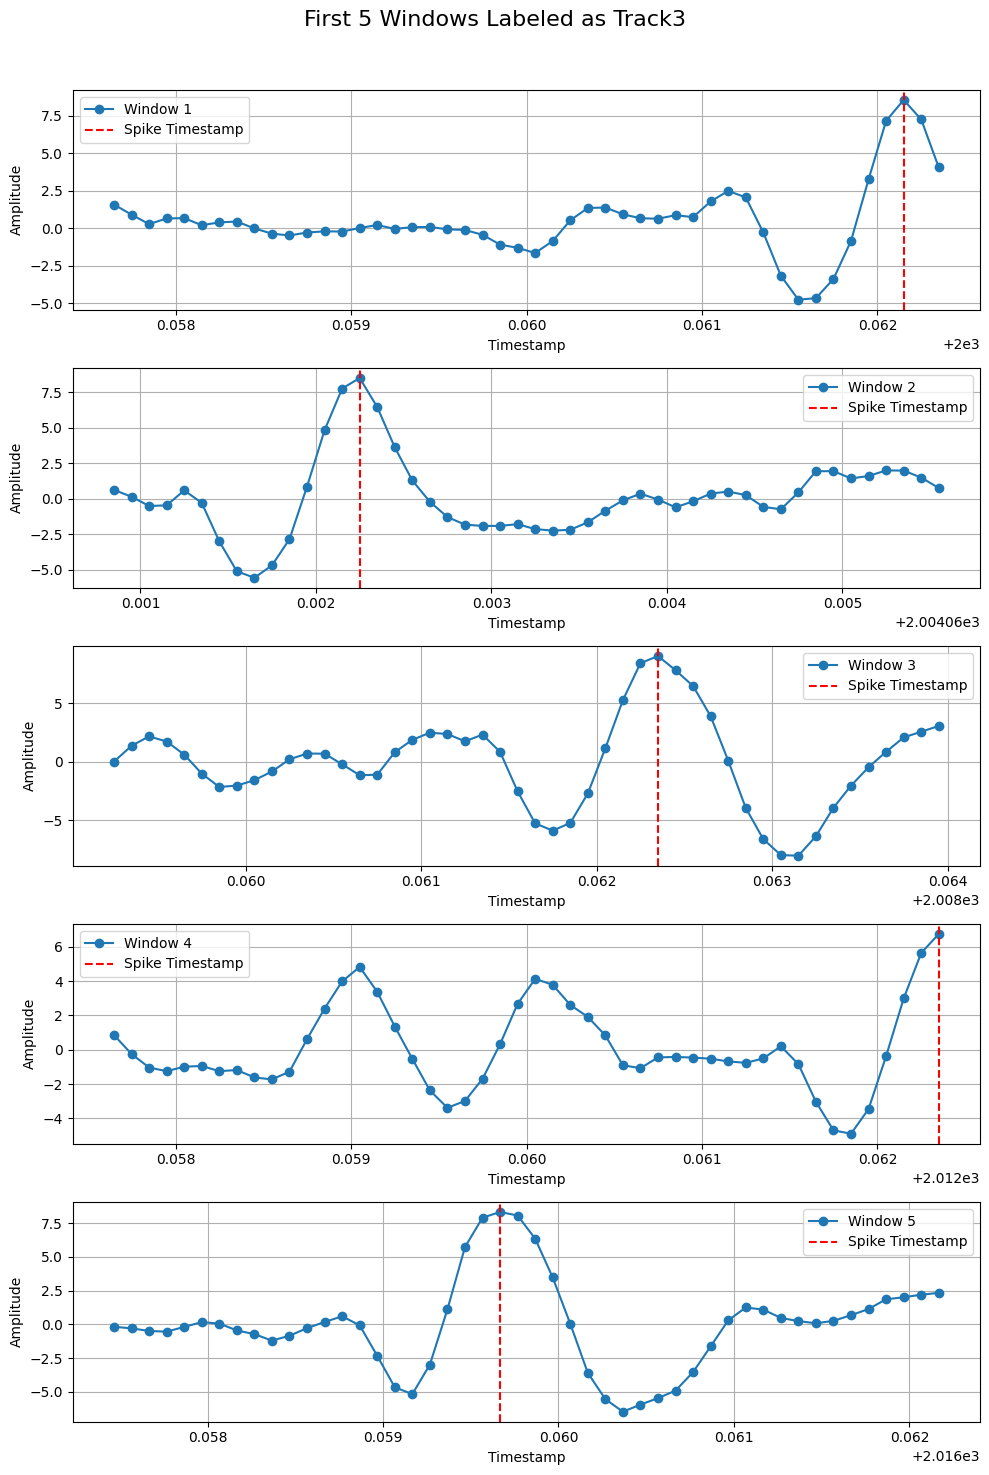

In [10]:
track_id = 'Track3'
x_windows = [amplitudes[i] for i in range(len(result_list)) if result_list[i] == track_id][:5]
x_times = [timestamps[i] for i in range(len(result_list)) if result_list[i] == track_id][:5]
# print([i for i in range(len(result_list)) if result_list[i] == 'Track4'][:5]) # [15, 848, 1681, 2515, 3327]
special_timestamps = [all_spike['ts'][i] for i in range(len(all_spike['track'])) if all_spike['track'][i] == track_id][:5] #all_spike[all_spike['track'] == 'Track4']['ts'][:5]

# Set up the figure and axes for subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
fig.suptitle("First 5 Windows Labeled as Track3", fontsize=16)

# Plot each of the first 5 windows labeled 'X'
for i in range(len(x_windows)):
    window_data = x_windows[i]
    times_data = x_times[i]

    # Plot amplitudes vs. timestamps
    axs[i].plot(times_data, window_data, marker='o', label=f"Window {i + 1}")

    # Mark special timestamps
    for ts in special_timestamps:
        if ts in times_data:
            axs[i].axvline(x=ts, color='red', linestyle='--', label=f'Spike Timestamp')

    axs[i].set_xlabel("Timestamp")
    axs[i].set_ylabel("Amplitude")
    axs[i].legend()
    axs[i].grid()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust to make room for the main title
plt.show()

In [92]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [110]:
torch.set_default_dtype(torch.float64)
replacement_dict = {'X': 1, 'Track3': 2, 'Track4': 3}
filtered_list = [replacement_dict.get(item, item) for item in result_list]
labels = torch.tensor(filtered_list, dtype=torch.int64)
samples = torch.tensor(amplitudes, dtype=torch.float64)

In [14]:

# manual 5-fold splitting

from torch.utils.data import DataLoader, TensorDataset, Subset

# Number of folds
k_folds = 5

# Shuffle the data
n_samples = samples.size(0)
indices = torch.randperm(n_samples)

# Split indices for 5 folds
fold_size = n_samples // k_folds
folds = [indices[i * fold_size:(i + 1) * fold_size] for i in range(k_folds)]

In [111]:
def one_hot_encode(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes)

num_classes = len(torch.unique(labels))
labels_onehot = one_hot_encode(labels, num_classes)
labels_onehot[10:15]

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]])

In [16]:
for fold in range(k_folds):
    print(f'Starting fold {fold + 1}')
    
    # Prepare the datasets and loaders as in the previous step
    test_idx = folds[fold]
    test_samples = samples[test_idx]
    test_labels = labels_onehot[test_idx]
    
    train_idx = torch.cat([folds[i] for i in range(k_folds) if i != fold])
    train_samples = samples[train_idx]
    train_labels = labels_onehot[train_idx]
    
    train_dataset = TensorDataset(train_samples, train_labels)
    test_dataset = TensorDataset(test_samples, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Train and evaluate the model for this fold
    num_train_batches = len(train_loader)
    num_test_batches = len(test_loader)
    print(f'Number of training batches: {num_train_batches}')
    print(f'Number of testing batches: {num_test_batches}')

    # Print shape of the first batch
    for batch_samples, batch_labels in train_loader:
        print(f'First batch samples shape: {batch_samples.shape}')
        print(f'First batch labels shape: {batch_labels.shape}')
        break  # Just print the first batch

Starting fold 1
Number of training batches: 4204
Number of testing batches: 1051
First batch samples shape: torch.Size([32, 48])
First batch labels shape: torch.Size([32, 4])
Starting fold 2
Number of training batches: 4204
Number of testing batches: 1051
First batch samples shape: torch.Size([32, 48])
First batch labels shape: torch.Size([32, 4])
Starting fold 3
Number of training batches: 4204
Number of testing batches: 1051
First batch samples shape: torch.Size([32, 48])
First batch labels shape: torch.Size([32, 4])
Starting fold 4
Number of training batches: 4204
Number of testing batches: 1051
First batch samples shape: torch.Size([32, 48])
First batch labels shape: torch.Size([32, 4])
Starting fold 5
Number of training batches: 4204
Number of testing batches: 1051
First batch samples shape: torch.Size([32, 48])
First batch labels shape: torch.Size([32, 4])


In [112]:
from torch.utils.data import DataLoader, TensorDataset, random_split
samples = samples.unsqueeze(1)
print(samples.shape)
samples = samples.to(device)
labels_onehot = labels_onehot.to(device)
dataset = TensorDataset(samples, labels_onehot.to(dtype=torch.float32))

# Calculate split sizes for 80/20 split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([168155, 1, 48])


In [14]:
print(torch.__version__)

2.4.1+cu118


In [113]:
from typing import Callable

def train(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, \
          n_epoch: int, optimizer: torch.optim.Optimizer, \
          criterion: Callable[[torch.Tensor | list[torch.Tensor]], torch.Tensor]) -> None:
    n_digits = len(str(n_epoch))
    for epoch in range(n_epoch):
        total_loss = 0
        total_accuracy = 0
        total_number = 0
        for data in data_loader:
            x, labels = data
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            classes = labels.argmax(dim=-1)
            y = outputs[0] if isinstance(outputs, tuple) else outputs
            y_classes = y.argmax(dim=-1)
            total_accuracy += (classes == y_classes).sum().item()
            total_number += labels.size(0)
        total_accuracy /= total_number / 100
        print(f'Epoch: {epoch+1:0{n_digits}d} / {n_epoch}, accuracy: {total_accuracy:.2f}%, loss: {total_loss:.4f}')

def test(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, \
         criterion: Callable[[torch.Tensor | list[torch.Tensor]], torch.Tensor]) -> tuple[float, float]:
    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        total_number = 0
        for data in data_loader:
            x, labels = data
            outputs = model(x)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            classes = labels.argmax(dim=-1)
            y = outputs[0] if isinstance(outputs, tuple) else outputs
            y_classes = y.argmax(dim=-1)
            total_accuracy += (classes == y_classes).sum().item()
            total_number += labels.size(0)
        total_accuracy /= total_number / 100
        print(f'Test accuracy: {total_accuracy:.2f}%, loss: {total_loss:.4f}')
        return total_accuracy, total_loss

In [97]:
if not torch.all(torch.isfinite(samples)):
    print("The tensor contains non-finite values.")
    # Optionally print the offending values
    non_finite_mask = ~torch.isfinite(samples)
    print("Non-finite values:", samples[non_finite_mask])

In [117]:

batch_size = 512
epoch = 1
lr = 0.1
dtype = torch.float64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# torch.use_deterministic_algorithms(True, warn_only=True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = False
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#samples0, labels0 = train_dataset[0]
n_channels, n_in = samples[0].shape
n_out = len(labels_onehot[0])
hidden1 = 3
weight_num = 2
affin = torch.tensor([6 / n_in, -0.3606]).tolist()
#affin = torch.tensor([6 / n_in, -0.3606]).tolist()  #semioptimal
weight = ((torch.rand(weight_num)-0.5)*8).tolist()
#weight = [3]

#model = VPNet(n_in, n_channels, 4, VPTypes.FEATURES, [0.1, 0], HermiteSystem(n_in, 4), [16], n_out, device=device, dtype=dtype)
criterion = VPLoss(torch.nn.CrossEntropyLoss(), 0.1)

model = VPNet(n_in, n_channels, hidden1, VPTypes.FEATURES, affin + weight, WeightedHermiteSystem(n_in, hidden1, weight_num), [hidden1], n_out, device=device, dtype=dtype)
#criterion = VPLoss(torch.nn.CrossEntropyLoss(), 0.1)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_loader, epoch, optimizer, criterion)
if isinstance(model, VPNet):
    print(*list(model.vp_layer.parameters()))
test(model, test_loader, criterion)
print()

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 2).